In [ ]:
import os
from dotenv import dotenv
load_dotenv()
hf_token=os.getenv("hf_token")

In [ ]:
from huggingface_hub import login

login(token=hf_token)

In [18]:
import torch 

torch.cuda.is_available()

True

In [ ]:
from pyannote.audio import Model
from pyannote.audio.core.inference import Inference
import torch

model = Model.from_pretrained("pyannote/segmentation-3.0",token=hf_token, use_auth_token=True)

segmentation = Inference(model, device=torch.device("cuda"))  # use "cpu" si no GPU


In [4]:
from datasets import load_dataset
import soundfile as sf

In [5]:
dataset = load_dataset(
    "igitsml/darija-synthetic-calls",
    split="train"
)

print(dataset)


Generating train split: 100%|██████████| 1998/1998 [00:34<00:00, 57.78 examples/s] 

Dataset({
    features: ['audio', 'speakers', 'timestamps_start', 'timestamps_end'],
    num_rows: 1998
})


In [6]:
from datasets import Audio

dataset = dataset.cast_column(
    "audio",
    Audio(decode=False)
)

In [31]:
import io
import soundfile as sf

audio_entry = dataset[0]["audio"]

audio_bytes = audio_entry["bytes"]

audio_array, sampling_rate = sf.read(io.BytesIO(audio_bytes))

print(len(audio_array), sampling_rate)

1222736 16000


In [7]:
dataset[0]

{'audio': {'bytes': b'RIFF\xfe\xf8\x01\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\xda\xf8\x01\x00]\xfa\x8b\xfb\xb1\xfd4\xff7\x00n\x00\xcd\xfe\xca\xfey\xfdf\xfb!\xfd\x05\xfe7\xfca\xfd@\xff0\xfed\xfda\xfe\xf5\xfft\x01\x06\x00\xca\xfe\xa3\x00\x99\x01C\x04P\x04s\x04\xdd\x07z\t\xf8\nw\x0cq\rr\r\xcf\r\xf5\r&\r9\x0c[\x0b\x02\nS\n\xcb\rI\x10p\x108\x11\xac\x10b\r\x9d\t*\x06\xa6\x01d\xfe\xc8\xfa\xb3\xf7#\xfa\n\xfe\x1f\xfc \xf9\xf9\xfa\x10\xfa\xff\xf9\x9e\xf9\xc6\xf6q\xf7u\xf7\xdc\xf5\x81\xf4\x02\xf4\x04\xf6\xf3\xf7\xd4\xf8\x84\xfc^\xfe\x16\xfd\x16\xfe\x87\x01x\xff\xaa\xfa6\xfb\xa5\xfaz\xf8\x07\xf8\x12\xf6D\xf44\xf7G\xf9B\xf9\xc7\xf9;\xfc\x18\xfc\x17\xfc\xd3\xfb\x9e\xfa\x9a\xfb\xb0\xfa\x04\xfb\xdf\xfa\xf4\xfc\x89\xff\x14\xfe=\xfd\x1a\xffC\x00\x99\x02T\x03\xec\x00\xd5\x01y\x04\x8b\x05y\x06\x18\n\x06\rZ\x0en\x0f\xc1\x0c\xa9\nm\x0c\xe9\r)\x0c\x1e\x0c\x87\rC\x0c\xd2\x0c\xf6\x0cN\x0c\x97\x0ck\x0c\x0f\n\xde\x08/\x08\xfb\x01\xdb\xfe\xad\xff\x04\xfd \xfbP\xf

In [ ]:

from functools import lru_cache
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from pyannote.audio.core.task import Problem
from pyannote.audio.models.blocks.sincnet import SincNet
from pyannote.audio.utils.params import merge_dict
from pyannote.core.utils.generators import pairwise


class Dict(dict):
    def __init__(self, *args, **kwargs):
        super(Dict, self).__init__(*args, **kwargs)
        self.__dict__ = self


class PyanNet_nn(torch.nn.Module):

    SINCNET_DEFAULTS = {"stride": 10}
    LSTM_DEFAULTS = {
        "hidden_size": 128,
        "num_layers": 4,
        "bidirectional": True,
        "monolithic": True,
        "dropout": 0.0,
    }
    LINEAR_DEFAULTS = {"hidden_size": 128, "num_layers": 2}

    def __init__(
        self,
        sincnet: Optional[dict] = None,
        lstm: Optional[dict] = None,
        linear: Optional[dict] = None,
        sample_rate: int = 16000,
        num_channels: int = 1,
    ):
        super(PyanNet_nn, self).__init__()

        sincnet = merge_dict(self.SINCNET_DEFAULTS, sincnet)
        sincnet["sample_rate"] = sample_rate
        lstm = merge_dict(self.LSTM_DEFAULTS, lstm)
        lstm["batch_first"] = True
        linear = merge_dict(self.LINEAR_DEFAULTS, linear)

        self.hparams = Dict(
            {
                "linear": {"hidden_size": 128, "num_layers": 2},
                "lstm": {
                    "hidden_size": 128,
                    "num_layers": 4,
                    "bidirectional": True,
                    "monolithic": True,
                    "dropout": 0.0,
                    "batch_first": True,
                },
                "num_channels": 1,
                "sample_rate": 16000,
                "sincnet": {"stride": 10, "sample_rate": 16000},
            }
        )

        self.sincnet = SincNet(**self.hparams.sincnet)

        monolithic = lstm["monolithic"]
        if monolithic:
            multi_layer_lstm = dict(lstm)
            del multi_layer_lstm["monolithic"]
            self.lstm = nn.LSTM(60, **multi_layer_lstm)

        else:
            num_layers = lstm["num_layers"]
            if num_layers > 1:
                self.dropout = nn.Dropout(p=lstm["dropout"])

            one_layer_lstm = dict(lstm)
            one_layer_lstm["num_layers"] = 1
            one_layer_lstm["dropout"] = 0.0
            del one_layer_lstm["monolithic"]

            self.lstm = nn.ModuleList(
                [
                    nn.LSTM(
                        60 if i == 0 else lstm["hidden_size"] * (2 if lstm["bidirectional"] else 1),
                        **one_layer_lstm,
                    )
                    for i in range(num_layers)
                ]
            )

        if linear["num_layers"] < 1:
            return

        lstm_out_features: int = self.hparams.lstm["hidden_size"] * (2 if self.hparams.lstm["bidirectional"] else 1)
        self.linear = nn.ModuleList(
            [
                nn.Linear(in_features, out_features)
                for in_features, out_features in pairwise(
                    [
                        lstm_out_features,
                    ]
                    + [self.hparams.linear["hidden_size"]] * self.hparams.linear["num_layers"]
                )
            ]
        )

    @property
    def dimension(self) -> int:
        if isinstance(self.specifications, tuple):
            raise ValueError("PyanNet does not support multi-tasking.")

        if self.specifications.powerset:
            return self.specifications.num_powerset_classes
        else:
            return len(self.specifications.classes)

    def default_activation(
        self,
    ):
        if self.specifications.problem == Problem.BINARY_CLASSIFICATION:
            return nn.Sigmoid()

        elif self.specifications.problem == Problem.MONO_LABEL_CLASSIFICATION:
            return nn.LogSoftmax(dim=-1)

        elif self.specifications.problem == Problem.MULTI_LABEL_CLASSIFICATION:
            return nn.Sigmoid()
        else:
            msg = "implement default activation for other types of problems"
            raise NotImplementedError(msg)

    def build(self):
        if self.hparams.linear["num_layers"] > 0:
            in_features = self.hparams.linear["hidden_size"]
        else:
            in_features = self.hparams.lstm["hidden_size"] * (2 if self.hparams.lstm["bidirectional"] else 1)

        self.classifier = nn.Linear(in_features, self.dimension)
        self.activation = self.default_activation()

    @lru_cache
    def num_frames(self, num_samples: int) -> int:

        return self.sincnet.num_frames(num_samples)

    def receptive_field_size(self, num_frames: int = 1) -> int:

        return self.sincnet.receptive_field_size(num_frames=num_frames)

    def receptive_field_center(self, frame: int = 0) -> int:

        return self.sincnet.receptive_field_center(frame=frame)

    def forward(self, waveforms: torch.Tensor) -> torch.Tensor:

        outputs = self.sincnet(waveforms)

        if self.hparams.lstm["monolithic"]:
            outputs, _ = self.lstm(rearrange(outputs, "batch feature frame -> batch frame feature"))
        else:
            outputs = rearrange(outputs, "batch feature frame -> batch frame feature")
            for i, lstm in enumerate(self.lstm):
                outputs, _ = lstm(outputs)
                if i + 1 < self.hparams.lstm["num_layers"]:
                    outputs = self.dropout(outputs)

        if self.hparams.linear["num_layers"] > 0:
            for linear in self.linear:
                outputs = F.leaky_relu(linear(outputs))

        return self.activation(self.classifier(outputs))

In [ ]:
import torch
import copy
import numpy as np
from typing import Optional

# Hugging Face
from transformers import PreTrainedModel
from transformers import PretrainedConfig
# Pyannote - specific imports may vary slightly by version
from pyannote.audio.core.task import Problem, Resolution, Specifications
#from pyannote.audio.core.model import Specifications
from pyannote.audio.models.segmentation import PyanNet
from pyannote.audio.utils.permutation import permutate
from pyannote.audio.utils.powerset import Powerset
from pyannote.audio.utils.loss import binary_cross_entropy, nll_loss

class SegmentationModelConfig(PretrainedConfig):

    model_type = "pyannet"

    def __init__(
        self,
        chunk_duration=10,
        max_speakers_per_frame=2,
        max_speakers_per_chunk=2,
        min_duration=None,
        warm_up=(0.0, 0.0),
        weigh_by_cardinality=False,
        **kwargs,
    ):

        super().__init__(**kwargs)
        self.chunk_duration = chunk_duration
        self.max_speakers_per_frame = max_speakers_per_frame
        self.max_speakers_per_chunk = max_speakers_per_chunk
        self.min_duration = min_duration
        self.warm_up = warm_up
        self.weigh_by_cardinality = weigh_by_cardinality
        # For now the model handles only 16000 Hz sampling rate
        self.sample_rate = 16000
class SegmentationModel(PreTrainedModel):
    config_class = SegmentationModelConfig

    def __init__(
        self,
        config=SegmentationModelConfig(),
    ):
        super().__init__(config)

        self.model = PyanNet_nn(sincnet={"stride": 10})

        self.weigh_by_cardinality = config.weigh_by_cardinality
        self.max_speakers_per_frame = config.max_speakers_per_frame
        self.chunk_duration = config.chunk_duration
        self.min_duration = config.min_duration
        self.warm_up = config.warm_up
        self.max_speakers_per_chunk = config.max_speakers_per_chunk

        self.specifications = Specifications(
            problem=Problem.MULTI_LABEL_CLASSIFICATION
            if self.max_speakers_per_frame is None
            else Problem.MONO_LABEL_CLASSIFICATION,
            resolution=Resolution.FRAME,
            duration=self.chunk_duration,
            min_duration=self.min_duration,
            warm_up=self.warm_up,
            classes=[f"speaker#{i+1}" for i in range(self.max_speakers_per_chunk)],
            powerset_max_classes=self.max_speakers_per_frame,
            permutation_invariant=True,
        )
        self.model.specifications = self.specifications
        self.model.build()
        self.setup_loss_func()

    def forward(self, waveforms, labels=None, nb_speakers=None):

        prediction = self.model(waveforms.unsqueeze(1))
        batch_size, num_frames, _ = prediction.shape

        if labels is not None:
            weight = torch.ones(batch_size, num_frames, 1, device=waveforms.device)
            warm_up_left = round(self.specifications.warm_up[0] / self.specifications.duration * num_frames)
            weight[:, :warm_up_left] = 0.0
            warm_up_right = round(self.specifications.warm_up[1] / self.specifications.duration * num_frames)
            weight[:, num_frames - warm_up_right :] = 0.0

            if self.specifications.powerset:
                multilabel = self.model.powerset.to_multilabel(prediction)
                permutated_target, _ = permutate(multilabel, labels)

                permutated_target_powerset = self.model.powerset.to_powerset(permutated_target.float())
                loss = self.segmentation_loss(prediction, permutated_target_powerset, weight=weight)

            else:
                permutated_prediction, _ = permutate(labels, prediction)
                loss = self.segmentation_loss(permutated_prediction, labels, weight=weight)

            return {"loss": loss, "logits": prediction}

        return {"logits": prediction}

    def setup_loss_func(self):
        if self.specifications.powerset:
            self.model.powerset = Powerset(
                len(self.specifications.classes),
                self.specifications.powerset_max_classes,
            )

    def segmentation_loss(
        self,
        permutated_prediction: torch.Tensor,
        target: torch.Tensor,
        weight: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:


        if self.specifications.powerset:
            # `clamp_min` is needed to set non-speech weight to 1.
            class_weight = torch.clamp_min(self.model.powerset.cardinality, 1.0) if self.weigh_by_cardinality else None
            seg_loss = nll_loss(
                permutated_prediction,
                torch.argmax(target, dim=-1),
                class_weight=class_weight,
                weight=weight,
            )
        else:
            seg_loss = binary_cross_entropy(permutated_prediction, target.float(), weight=weight)

        return seg_loss

    @classmethod
    def from_pyannote_model(cls, pretrained):

        # Initialize model:
        specifications = copy.deepcopy(pretrained.specifications)

        # Copy pretrained model hyperparameters:
        chunk_duration = specifications.duration
        max_speakers_per_frame = specifications.powerset_max_classes
        weigh_by_cardinality = False
        min_duration = specifications.min_duration
        warm_up = specifications.warm_up
        max_speakers_per_chunk = len(specifications.classes)

        config = SegmentationModelConfig(
            chunk_duration=chunk_duration,
            max_speakers_per_frame=max_speakers_per_frame,
            weigh_by_cardinality=weigh_by_cardinality,
            min_duration=min_duration,
            warm_up=warm_up,
            max_speakers_per_chunk=max_speakers_per_chunk,
        )

        model = cls(config)

        # Copy pretrained model weights:
        model.model.hparams = copy.deepcopy(pretrained.hparams)
        model.model.sincnet = copy.deepcopy(pretrained.sincnet)
        model.model.sincnet.load_state_dict(pretrained.sincnet.state_dict())
        model.model.lstm = copy.deepcopy(pretrained.lstm)
        model.model.lstm.load_state_dict(pretrained.lstm.state_dict())
        model.model.linear = copy.deepcopy(pretrained.linear)
        model.model.linear.load_state_dict(pretrained.linear.state_dict())
        model.model.classifier = copy.deepcopy(pretrained.classifier)
        model.model.classifier.load_state_dict(pretrained.classifier.state_dict())
        model.model.activation = copy.deepcopy(pretrained.activation)
        model.model.activation.load_state_dict(pretrained.activation.state_dict())

        return model

    def to_pyannote_model(self):

        seg_model = PyanNet(sincnet={"stride": 10})
        seg_model.hparams.update(self.model.hparams)

        seg_model.sincnet = copy.deepcopy(self.model.sincnet)
        seg_model.sincnet.load_state_dict(self.model.sincnet.state_dict())

        seg_model.lstm = copy.deepcopy(self.model.lstm)
        seg_model.lstm.load_state_dict(self.model.lstm.state_dict())

        seg_model.linear = copy.deepcopy(self.model.linear)
        seg_model.linear.load_state_dict(self.model.linear.state_dict())

        seg_model.classifier = copy.deepcopy(self.model.classifier)
        seg_model.classifier.load_state_dict(self.model.classifier.state_dict())

        seg_model.activation = copy.deepcopy(self.model.activation)
        seg_model.activation.load_state_dict(self.model.activation.state_dict())

        seg_model.specifications = self.specifications

        return seg_model
    


In [49]:
torch.__version__

'2.5.1+cu121'

In [ ]:
import math
import gc
import numpy as np
import torch
import io
import soundfile as sf

class Preprocess:
    def __init__(
        self,
        config,
    ):

        self.chunk_duration = config.chunk_duration
        self.max_speakers_per_frame = config.max_speakers_per_frame
        self.max_speakers_per_chunk = config.max_speakers_per_chunk
        self.min_duration = config.min_duration
        self.warm_up = config.warm_up

        self.sample_rate = config.sample_rate
        self.model = SegmentationModel(config).to_pyannote_model()

        # Get the number of frames associated to a chunk:
        _, self.num_frames_per_chunk, _ = self.model(
            torch.rand((1, int(self.chunk_duration * self.sample_rate)))
        ).shape

    def get_labels_in_file(self, file):


        file_labels = []
        for i in range(len(file["speakers"][0])):
            if file["speakers"][0][i] not in file_labels:
                file_labels.append(file["speakers"][0][i])

        return file_labels

    def get_segments_in_file(self, file, labels):


        file_annotations = []

        for i in range(len(file["timestamps_start"][0])):
            start_segment = file["timestamps_start"][0][i]
            end_segment = file["timestamps_end"][0][i]
            label = labels.index(file["speakers"][0][i])
            file_annotations.append((start_segment, end_segment, label))

        dtype = [("start", "<f4"), ("end", "<f4"), ("labels", "i1")]

        annotations = np.array(file_annotations, dtype)

        return annotations

    def get_chunk(self, file, start_time):


        bio = io.BytesIO(file["audio"][0]["bytes"])

        
        audio_array, sample_rate = sf.read(bio)
        del bio
        assert sample_rate == self.sample_rate

        end_time = start_time + self.chunk_duration
        start_frame = math.floor(start_time * sample_rate)
        num_frames_waveform = math.floor(self.chunk_duration * sample_rate)
        end_frame = start_frame + num_frames_waveform
        

        waveform = audio_array[start_frame:end_frame].copy()
        del audio_array 
        gc.collect()
        labels = self.get_labels_in_file(file)

        file_segments = self.get_segments_in_file(file, labels)

        chunk_segments = file_segments[(file_segments["start"] < end_time) & (file_segments["end"] > start_time)]


        step = self.model.receptive_field.step
        half = 0.5 * self.model.receptive_field.duration

        start = np.maximum(chunk_segments["start"], start_time) - start_time - half
        start_idx = np.maximum(0, np.round(start / step)).astype(int)

        end = np.minimum(chunk_segments["end"], end_time) - start_time - half
        end_idx = np.round(end / step).astype(int)
        labels = list(np.unique(chunk_segments["labels"]))
        num_labels = len(labels)
        y = np.zeros((self.num_frames_per_chunk, num_labels), dtype=np.uint8)

        mapping = {label: idx for idx, label in enumerate(labels)}

        for start, end, label in zip(start_idx, end_idx, chunk_segments["labels"]):
            mapped_label = mapping[label]
            y[start : end + 1, mapped_label] = 1
        
        gc.collect()
        return waveform, y, labels

    def get_start_positions(self, file, overlap, random=False):
        
        bio = io.BytesIO(file["audio"][0]["bytes"])

        audio_array, sample_rate = sf.read(bio)
        del bio

        assert sample_rate == self.sample_rate

        file_duration = len(audio_array) / sample_rate
        start_positions = np.arange(0, file_duration - self.chunk_duration, self.chunk_duration * (1 - overlap))
        del audio_array
        if random:
            nb_samples = int(file_duration / self.chunk_duration)
            start_positions = np.random.uniform(0, file_duration, nb_samples)
        
        gc.collect()
        return start_positions

    def __call__(self, file, random=False, overlap=0.0):

        new_batch = {"waveforms": [], "labels": [], "nb_speakers": []}

        if random:
            start_positions = self.get_start_positions(file, overlap, random=True)
        else:
            start_positions = self.get_start_positions(file, overlap)

        for start_time in start_positions:
            waveform, target, label = self.get_chunk(file, start_time)

            new_batch["waveforms"].append(waveform)
            new_batch["labels"].append(target)
            new_batch["nb_speakers"].append(label)

        return new_batch

In [76]:
model = SegmentationModel.from_pyannote_model(model)
preprocessor = Preprocess(model.config)

/home/lamhaourii/Documents/2a/wttf/.venv/lib/python3.10/site-packages/asteroid_filterbanks/enc_dec.py:202: UserWarning: Input tensor was 2D. Applying the corresponding Decoder to the current output will result in a 3D tensor. This behaviours was introduced to match Conv1D and ConvTranspose1D, please use 3D inputs to avoid it. For example, this can be done with input_tensor.unsqueeze(1).
  warnings.warn(


In [42]:
preprocessor = Preprocess(model.config)

In [77]:
model.config

SegmentationModelConfig {
  "chunk_duration": 10.0,
  "max_speakers_per_chunk": 3,
  "max_speakers_per_frame": 2,
  "min_duration": null,
  "model_type": "pyannet",
  "sample_rate": 16000,
  "transformers_version": "4.57.3",
  "warm_up": [
    0.0,
    0.0
  ],
  "weigh_by_cardinality": false
}

In [12]:
from datasets import DatasetDict

train_testvalid = dataset.train_test_split(test_size=0.2, seed=0)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=0)

dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['test'],
    'test': test_valid['train']}
)

In [60]:
train_set = dataset['train'].map(
    lambda file: preprocessor(file, random=False, overlap=0.5),
    remove_columns=next(iter(dataset.values())).column_names,
    num_proc=2,
    batched=True,
    batch_size=1,          
    writer_batch_size=100,  
    keep_in_memory=False
).with_format("torch")
val_set = dataset['validation'].map(
    lambda file: preprocessor(file, random=False, overlap=0.0),
    remove_columns=next(iter(dataset.values())).column_names,
    num_proc=2,
    batched=True,
    batch_size=1, 
    writer_batch_size=100,  
    keep_in_memory=False
).with_format("torch")

Map (num_proc=2): 100%|██████████| 200/200 [05:45<00:00,  1.73s/ examples]


In [72]:
test_set = dataset['test'].map(
    lambda file: preprocessor(file, random=False, overlap=0.0),
    remove_columns=next(iter(dataset.values())).column_names,
    num_proc=2,
    batched=True,
    batch_size=1, 
    writer_batch_size=100,  
    keep_in_memory=False
).with_format("torch")

Map (num_proc=2): 100%|██████████| 200/200 [06:03<00:00,  1.82s/ examples]


In [61]:
import numpy as np
import torch
from pyannote.audio.torchmetrics import (DiarizationErrorRate, FalseAlarmRate,
                                         MissedDetectionRate,
                                         SpeakerConfusionRate)
from pyannote.audio.utils.powerset import Powerset

In [ ]:
class DataCollator:

    def __init__(self, max_speakers_per_chunk) -> None:
        self.max_speakers_per_chunk = max_speakers_per_chunk

    def __call__(self, features):

        batch = {}

        speakers = [f["nb_speakers"] for f in features]
        labels = [f["labels"] for f in features]

        batch["labels"] = self.pad_targets(labels, speakers)

        batch["waveforms"] = torch.stack([f["waveforms"] for f in features])
        

        return batch

    def pad_targets(self, labels, speakers):

        targets = []

        for i in range(len(labels)):
            label = speakers[i]
            target = labels[i].numpy()
            num_speakers = len(label)

            if num_speakers > self.max_speakers_per_chunk:
                indices = np.argsort(-np.sum(target, axis=0), axis=0)
                target = target[:, indices[: self.max_speakers_per_chunk]]

            elif num_speakers < self.max_speakers_per_chunk:
                target = np.pad(
                    target,
                    ((0, 0), (0, self.max_speakers_per_chunk - num_speakers)),
                    mode="constant",
                )

            targets.append(target)

        return torch.from_numpy(np.stack(targets))

In [ ]:
class Metrics:
    def __init__(self, specifications) -> None:

        self.powerset = specifications.powerset
        self.classes = specifications.classes
        self.powerset_max_classes = specifications.powerset_max_classes

        self.model_powerset = Powerset(
            len(self.classes),
            self.powerset_max_classes,
        )

        self.metrics = {
            "der": DiarizationErrorRate(0.5),
            "confusion": SpeakerConfusionRate(0.5),
            "missed_detection": MissedDetectionRate(0.5),
            "false_alarm": FalseAlarmRate(0.5),
        }

    def __call__(self, eval_pred):

        logits, labels = eval_pred

        if self.powerset:
            predictions = self.model_powerset.to_multilabel(torch.tensor(logits))
        else:
            predictions = torch.tensor(logits)

        labels = torch.tensor(labels)

        predictions = torch.transpose(predictions, 1, 2)
        labels = torch.transpose(labels, 1, 2)

        metrics = {"der": 0, "false_alarm": 0, "missed_detection": 0, "confusion": 0}

        metrics["der"] += self.metrics["der"](predictions, labels).cpu().numpy()
        metrics["false_alarm"] += self.metrics["false_alarm"](predictions, labels).cpu().numpy()
        metrics["missed_detection"] += self.metrics["missed_detection"](predictions, labels).cpu().numpy()
        metrics["confusion"] += self.metrics["confusion"](predictions, labels).cpu().numpy()

        return metrics

In [68]:
data_collator = DataCollator(max_speakers_per_chunk=model.config.max_speakers_per_chunk)
metrics = Metrics(model.specifications)


In [69]:
from transformers import TrainingArguments

training_args = TrainingArguments( output_dir='./speaker-segmentation-darija',
                                  save_strategy="epoch",
                                  learning_rate=1e-5,
                                  warmup_ratio=0.1,
                                  num_train_epochs=5,
                                  lr_scheduler_type="cosine",
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  eval_strategy="epoch",
                                  gradient_accumulation_steps=8,
                                  fp16=True,
                                  dataloader_num_workers=0,
                                  logging_steps=25,
                                  load_best_model_at_end=True,
                                  seed=42,
                                  push_to_hub=True,
                                  hub_model_id="igitsml/speaker-segmentation-darija")

In [70]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    data_collator=data_collator,
    eval_dataset=val_set,
    compute_metrics=metrics,
)

In [65]:
first_eval = trainer.evaluate()
first_eval

Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])


Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size([4, 589, 3])
Waveform shape: torch.Size([4, 160000])
Labels shape: torch.Size

{'eval_loss': 0.952549934387207,
 'eval_model_preparation_time': 0.005,
 'eval_der': 0.25171563029289246,
 'eval_false_alarm': 0.03558219224214554,
 'eval_missed_detection': 0.04390125721693039,
 'eval_confusion': 0.17223216593265533,
 'eval_runtime': 23.336,
 'eval_samples_per_second': 60.893,
 'eval_steps_per_second': 15.255}

In [71]:
trainer.train()

Epoch,Training Loss,Validation Loss,Der,False Alarm,Missed Detection,Confusion
1,0.578100,0.666547,0.214367,0.035677,0.040548,0.138142
2,0.496400,0.549210,0.191157,0.032354,0.038140,0.120662
3,0.470100,0.505833,0.182009,0.031070,0.036923,0.114016
4,0.458500,0.495156,0.179216,0.030656,0.036429,0.112132
5,0.428000,0.493685,0.179173,0.030622,0.036376,0.112175


TrainOutput(global_step=3415, training_loss=0.523974658524833, metrics={'train_runtime': 2512.2699, 'train_samples_per_second': 43.449, 'train_steps_per_second': 1.359, 'total_flos': 0.0, 'train_loss': 0.523974658524833, 'epoch': 5.0})

In [73]:
test=trainer.evaluate(eval_dataset=test_set)
test

{'eval_loss': 0.4728706479072571,
 'eval_der': 0.17002888023853302,
 'eval_false_alarm': 0.029475385323166847,
 'eval_missed_detection': 0.03573576360940933,
 'eval_confusion': 0.10481773316860199,
 'eval_runtime': 21.6233,
 'eval_samples_per_second': 64.699,
 'eval_steps_per_second': 16.186,
 'epoch': 5.0}

In [88]:
training_args2 = TrainingArguments( output_dir='./speaker-segmentation-darija2',
                                  save_strategy="epoch",
                                  learning_rate=1e-5,
                                  warmup_ratio=0.1,
                                  weight_decay=0.05,
                                  num_train_epochs=30,
                                  lr_scheduler_type="cosine",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=8,
                                  eval_strategy="epoch",
                                  gradient_accumulation_steps=2,
                                  fp16=True,
                                  dataloader_num_workers=0,
                                  logging_steps=25,
                                  load_best_model_at_end=True,
                                  seed=42,
                                  push_to_hub=True,
                                  hub_model_id="igitsml/speaker-segmentation-darija2")

In [89]:
from transformers import TrainingArguments, EarlyStoppingCallback
trainer2 = Trainer(
    model=model,
    args=training_args2,
    train_dataset=train_set,
    data_collator=data_collator,
    eval_dataset=val_set,
    compute_metrics=metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [90]:
trainer2.evaluate()

{'eval_loss': 0.9497972130775452,
 'eval_model_preparation_time': 0.0061,
 'eval_der': 0.2517893612384796,
 'eval_false_alarm': 0.03561783954501152,
 'eval_missed_detection': 0.04392584040760994,
 'eval_confusion': 0.17224569618701935,
 'eval_runtime': 17.3759,
 'eval_samples_per_second': 81.78,
 'eval_steps_per_second': 10.244}

In [91]:
trainer2.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Der,False Alarm,Missed Detection,Confusion
1,0.716400,0.850041,0.006100,0.240647,0.036502,0.043220,0.160925
2,0.607500,0.686777,0.006100,0.218244,0.036123,0.040838,0.141283
3,0.521300,0.565894,0.006100,0.194710,0.032869,0.039461,0.122379
4,0.466400,0.504033,0.006100,0.182127,0.030618,0.037245,0.114264
5,0.411000,0.467821,0.006100,0.173755,0.029699,0.035490,0.108566
6,0.420500,0.450316,0.006100,0.168250,0.028604,0.034823,0.104823
7,0.413300,0.433047,0.006100,0.162903,0.028462,0.033572,0.100869
8,0.393600,0.419145,0.006100,0.157890,0.027822,0.032873,0.097195
9,0.379900,0.408036,0.006100,0.152935,0.027567,0.032287,0.093082
10,0.355700,0.400679,0.006100,0.150025,0.026947,0.031700,0.091377


TrainOutput(global_step=20490, training_loss=0.3913940842992914, metrics={'train_runtime': 10607.2917, 'train_samples_per_second': 61.743, 'train_steps_per_second': 1.932, 'total_flos': 0.0, 'train_loss': 0.3913940842992914, 'epoch': 30.0})

In [92]:
test2=trainer2.evaluate(eval_dataset=test_set)

In [93]:
test2

{'eval_loss': 0.3337574303150177,
 'eval_model_preparation_time': 0.0061,
 'eval_der': 0.12195303291082382,
 'eval_false_alarm': 0.023546649143099785,
 'eval_missed_detection': 0.029574383050203323,
 'eval_confusion': 0.06883199512958527,
 'eval_runtime': 25.654,
 'eval_samples_per_second': 54.533,
 'eval_steps_per_second': 6.822,
 'epoch': 30.0}

In [96]:
kwargs = {
    "dataset_tags":'igitsml/darija-synthetic-calls',
    "dataset_args": "config: darija",
    "language": "ar",
    "model_name": "speaker-segmentation-fine-tuned-darija",
    "finetuned_from": "pyannote/speaker-diarization-3.1",
    "tasks": "speaker-diarization",
    "tags": ['speaker-diarization', 'speaker-segmentation']
}

In [116]:
trainer2.push_to_hub(**kwargs)

Processing Files (2 / 2): 100%|██████████| 5.90MB / 5.90MB,  0.00B/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  


CommitInfo(commit_url='https://huggingface.co/igitsml/speaker-segmentation-darija2/commit/73bfcaf7661bf9d37d1db5d187a524a722b3d5f5', commit_message='End of training', commit_description='', oid='73bfcaf7661bf9d37d1db5d187a524a722b3d5f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/igitsml/speaker-segmentation-darija2', endpoint='https://huggingface.co', repo_type='model', repo_id='igitsml/speaker-segmentation-darija2'), pr_revision=None, pr_num=None)

In [118]:
trainer2.save_model("./my_finetuned_model")

Processing Files (2 / 2): 100%|██████████| 5.90MB / 5.90MB,  0.00B/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  


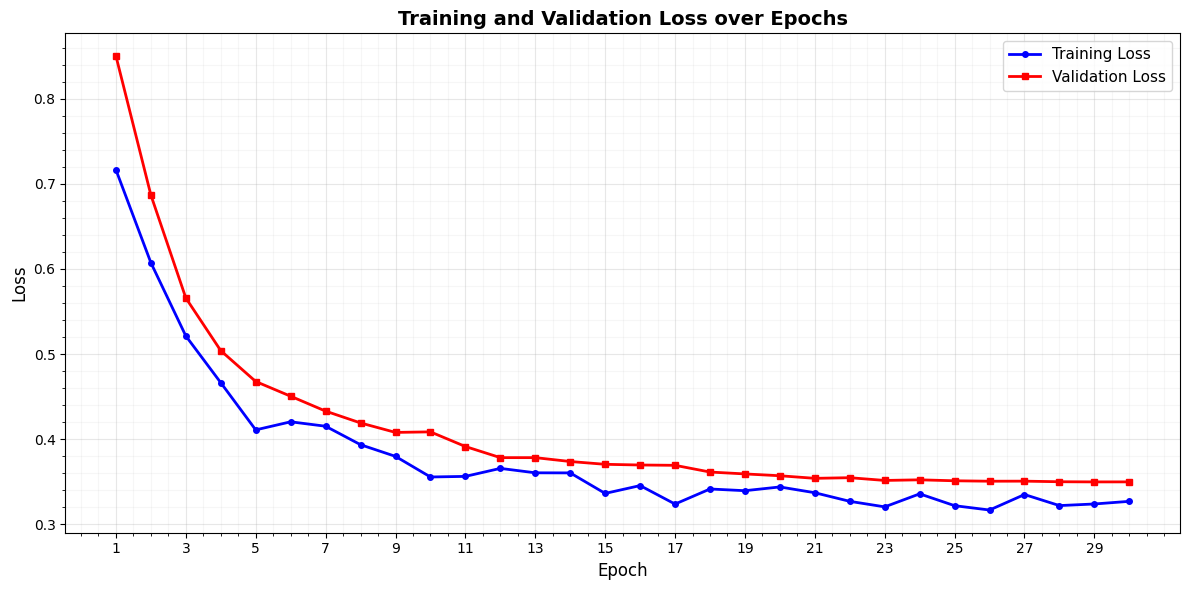

Training Loss:
  Initial: 0.716400
  Final: 0.327100
  Minimum: 0.316900 at epoch 26

Validation Loss:
  Initial: 0.850041
  Final: 0.349944
  Minimum: 0.349918 at epoch 29


In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 31))

training_loss = [
    0.716400, 0.607300, 0.521300, 0.466400, 0.411000,
    0.420500, 0.415300, 0.393600, 0.379900, 0.355700,
    0.356400, 0.365800, 0.360600, 0.360500, 0.336400,
    0.345600, 0.323900, 0.341600, 0.339600, 0.344000,
    0.337200, 0.327100, 0.320600, 0.335900, 0.322000,
    0.316900, 0.335100, 0.322100, 0.324000, 0.327100
]

validation_loss = [
    0.850041, 0.686777, 0.565894, 0.504033, 0.467821,
    0.450516, 0.433047, 0.419145, 0.408036, 0.408679,
    0.391489, 0.378422, 0.378422, 0.373862, 0.370574,
    0.369768, 0.369398, 0.361502, 0.359290, 0.357152,
    0.354110, 0.354859, 0.351641, 0.352364, 0.351237,
    0.350727, 0.350800, 0.350109, 0.349918, 0.349944
]

plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
plt.plot(epochs, validation_loss, 'r-s', label='Validation Loss', linewidth=2, markersize=4)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(epochs[::2])  

plt.minorticks_on()
plt.grid(which='minor', alpha=0.1)

plt.tight_layout()
plt.show()

print("Training Loss:")
print(f"  Initial: {training_loss[0]:.6f}")
print(f"  Final: {training_loss[-1]:.6f}")
print(f"  Minimum: {min(training_loss):.6f} at epoch {training_loss.index(min(training_loss)) + 1}")

print("\nValidation Loss:")
print(f"  Initial: {validation_loss[0]:.6f}")
print(f"  Final: {validation_loss[-1]:.6f}")
print(f"  Minimum: {min(validation_loss):.6f} at epoch {validation_loss.index(min(validation_loss)) + 1}")